# JUDGING A BOOK BY ITS COVER..!

In [1]:
pip install imutils


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import imutils 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Hyperparameters

In [3]:
# Parameter for comparing histograms
correl_threshold = 0.9

# Parameters for SSIM comparison
similarity_index_threshold = 0.0
ssim_matches_limit = 1000

# Parameters for SIFT comparision
sift_features_limit = 1000
lowe_ratio = 0.75
predictions_count = 4

# Parameters to display results
query_image_number = 0
amazon_reviews_count = 3

### Loading train and query images

In [4]:
import pandas as pd

# Replace 'your_file.csv' with the actual file name
data = pd.read_csv('shortbook.csv', encoding = "ISO-8859-1")


In [5]:
columns = ['Id', 'Image', 'Image_link', 'Title', 'Author', 'Class', 'Genre']
data.columns = columns

print(data.columns)

Index(['Id', 'Image', 'Image_link', 'Title', 'Author', 'Class', 'Genre'], dtype='object')


In [6]:
books = pd.DataFrame(data['Title'])
genre = pd.DataFrame(data['Genre'])

##read imageLink
image_link = pd.DataFrame(data['Image_link'])

#for link in image_link['Image_link']:
 #   print(link)
 

In [7]:
print (books.shape)
print (genre.shape)

(855, 1)
(855, 1)


In [8]:
data['Author'] = data['Author'].fillna('No Book')
data['Title'] = data['Title'].fillna('No Book')

In [9]:
genre['Genre'].unique()

array(['Calendars', 'Comics & Graphic Novels', 'Test Preparation',
       'Science Fiction & Fantasy', 'Romance', 'Humor & Entertainment',
       'Literature & Fiction', 'Gay & Lesbian',
       'Engineering & Transportation', 'Cookbooks, Food & Wine',
       'Crafts, Hobbies & Home', 'Self-Help', 'Computers & Technology',
       'Medical Books', 'Science & Math', 'Health, Fitness & Dieting',
       'Business & Money', 'Law', 'Biographies & Memoirs', 'History',
       'Politics & Social Sciences', 'Reference',
       'Christian Books & Bibles', 'Religion & Spirituality',
       'Teen & Young Adult', "Children's Books", 'Travel'], dtype=object)

In [10]:
#convert image to vector
import requests
from PIL import Image
from io import BytesIO


def image_to_vector(image_link):
    response = requests.get(image_link)
    img = Image.open(BytesIO(response.content))
    img = img.resize((100, 100))
    return np.array(img)


In [11]:
def imshow(im_title, im):
    ''' This is function to display the image'''
    plt.figure(figsize=(5,5))
    plt.title(im_title)
    plt.axis("off")
    if len(im.shape) == 2:
        plt.imshow(im, cmap = "gray")
    else:
        im_display = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.imshow(im_display)
    plt.show()

In [12]:
#divide the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_link, genre, test_size=0.2, random_state=42)


### RGB 3D 8-bin Color histogram of train data

In [13]:
import urllib.request
import cv2
import numpy as np
import matplotlib.pyplot as plt

hist_train = []

for link in X_train['Image_link']:
   
    if link is None:
        continue

    # Download the image from the URL
    try:
        req = urllib.request.urlopen(link)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        image = cv2.imdecode(arr, -1)  # Load image as is including alpha channel
    except Exception as e:
        print(f"Error downloading or reading image from {link}: {e}")
        continue
    
    if image is None:
        print(f"Failed to read image from {link}")
        continue
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Show image
   # plt.imshow(image_rgb)
   # plt.title('Image')
   # plt.axis('off')
   # plt.show()
    
    # Extract a 3D RGB color histogram from the image
    hist = cv2.calcHist([image_rgb], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    
    # Flatten the histogram
    hist_flat = hist.flatten()
    
    # Show the histogram
   # plt.figure()
   # plt.title('Histogram')
   # plt.plot(hist_flat)
   # plt.xlim([0, len(hist_flat)])
    #plt.show()
    
    hist_train.append((link, hist))
    
print("Total histograms computed:", len(hist_train))


In [ ]:
# Saving the train data histograms to a pickle file

with open('train_hist_data.pkl', 'wb') as f:
    pickle.dump(hist_train, f)

In [ ]:
# Loading the train data histograms from pickle file

with open('train_hist_data.pkl', 'rb') as f:
    hist_train = pickle.load(f)

len(hist_train)

683

### RGB 3D 8-bin Color histogram of query data

In [ ]:
import urllib.request
import cv2
import numpy as np
import matplotlib.pyplot as plt

hist_query = []

for link in X_test['Image_link']:
   
    if link is None:
        continue

    # Download the image from the URL
    try:
        req = urllib.request.urlopen(link)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        image = cv2.imdecode(arr, -1)  # Load image as is including alpha channel
    except Exception as e:
        print(f"Error downloading or reading image from {link}: {e}")
        continue
    
    if image is None:
        print(f"Failed to read image from {link}")
        continue
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Show image
   # plt.imshow(image_rgb)
   # plt.title('Image')
   # plt.axis('off')
   # plt.show()
    
    # Extract a 3D RGB color histogram from the image
    hist = cv2.calcHist([image_rgb], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    
    # Flatten the histogram
    hist_flat = hist.flatten()
    
    # Show the histogram
   # plt.figure()
   # plt.title('Histogram')
   # plt.plot(hist_flat)
   # plt.xlim([0, len(hist_flat)])
    #plt.show()
    
    hist_query.append((link,hist))
    
print("Total histograms computed:", len(hist_query))


Total histograms computed: 171


### Calculating matches for query images from train data

In [ ]:
hist_matches = []
for i in range(len(hist_query)):
    matches = []
    for j in range(len(hist_train)):
        cmp = cv2.compareHist(hist_query[i][1], hist_train[j][1], cv2.HISTCMP_CORREL)
        if cmp > correl_threshold:
            matches.append((cmp,hist_train[j][0]))
    matches.sort(key=lambda x : x[0] , reverse = True)
    hist_matches.append((hist_query[i][0],matches))
    
    #size of the matches
   # print(len(matches)
print(hist_matches[0])

('http://ecx.images-amazon.com/images/I/51-lS7T%2BOqL.jpg', [])


In [ ]:
# print hist matches of first 5
for i in range(5):
    print("matches for", i, "th book from query " ,hist_matches[i])
    
        

matches for 0 th book from query  ('http://ecx.images-amazon.com/images/I/51-lS7T%2BOqL.jpg', [])
matches for 1 th book from query  ('http://ecx.images-amazon.com/images/I/51vNgaGergL.jpg', [])
matches for 2 th book from query  ('http://ecx.images-amazon.com/images/I/514hXvtWVaL.jpg', [(3.3907084152990765, 'http://ecx.images-amazon.com/images/I/51DKUss0h5L.jpg'), (0.9984296388475054, 'http://ecx.images-amazon.com/images/I/410IkGE05ZL.jpg'), (0.9978741633764706, 'http://ecx.images-amazon.com/images/I/410TYBaP0aL.jpg'), (0.997795975705704, 'http://ecx.images-amazon.com/images/I/41MY223q%2B5L.jpg'), (0.997524002092574, 'http://ecx.images-amazon.com/images/I/41PWHPMDhsL.jpg'), (0.9973486935210436, 'http://ecx.images-amazon.com/images/I/41JNY2cq%2BNL.jpg'), (0.9968824851796146, 'http://ecx.images-amazon.com/images/I/41faGjqspHL.jpg'), (0.9968138599653693, 'http://ecx.images-amazon.com/images/I/31uwUQ%2B1cKL.jpg'), (0.9967448722059971, 'http://ecx.images-amazon.com/images/I/41AC3FIRa9L.jpg')

In [ ]:

for i in range(len(hist_matches[query_image_number][1])):
    print(hist_matches[query_image_number][1][i])
   # imshow("", cv2.imread(hist_matches[query_image_number][1][i][1]))

### Structural Similarity Index Matching (SSIM) on query images and their matches from color histogram

In [ ]:

from skimage.metrics import structural_similarity as ssim


In [ ]:
import requests
from PIL import Image
from io import BytesIO

def image_to_vector(image_link):
    try:
        response = requests.get(image_link)
        response.raise_for_status()  # Raise an exception for 4XX or 5XX status codes
        img = Image.open(BytesIO(response.content))
        img = img.resize((100, 100))
        return np.array(img)
    except Exception as e:
        print(f"Error reading image from {image_link}: {str(e)}")
        return None





In [ ]:
def similarity_index(q_path, m_path):
    q_i = image_to_vector(q_path)
    m_i = image_to_vector(m_path)
    
    if q_i is None or m_i is None:
        return None  # Return None if either image is None
    
    return ssim(q_i, m_i, win_size=3)  # Adjust the window size as needed

In [ ]:
ssim_matches = []

for i in range(len(hist_matches)):
    query_image_path = hist_matches[i][0]
    print(query_image_path)
    matches = []
    for j in range(len(hist_matches[i][1])):
        match_image_path = hist_matches[i][1][j][1]
        print(match_image_path)
        si = similarity_index(query_image_path,match_image_path)
        if si > similarity_index_threshold:
            matches.append((si,match_image_path))
    matches.sort(key=lambda x : x[0] , reverse = True)
    ssim_matches.append((query_image_path,matches[:ssim_matches_limit]))

http://ecx.images-amazon.com/images/I/51-lS7T%2BOqL.jpg
http://ecx.images-amazon.com/images/I/51vNgaGergL.jpg
http://ecx.images-amazon.com/images/I/514hXvtWVaL.jpg
http://ecx.images-amazon.com/images/I/51DKUss0h5L.jpg
http://ecx.images-amazon.com/images/I/410IkGE05ZL.jpg
http://ecx.images-amazon.com/images/I/410TYBaP0aL.jpg
http://ecx.images-amazon.com/images/I/41MY223q%2B5L.jpg
http://ecx.images-amazon.com/images/I/41PWHPMDhsL.jpg
http://ecx.images-amazon.com/images/I/41JNY2cq%2BNL.jpg
http://ecx.images-amazon.com/images/I/41faGjqspHL.jpg
http://ecx.images-amazon.com/images/I/31uwUQ%2B1cKL.jpg
http://ecx.images-amazon.com/images/I/41AC3FIRa9L.jpg
http://ecx.images-amazon.com/images/I/41eR-7vJrbL.jpg
http://ecx.images-amazon.com/images/I/41vKcBbAtdL.jpg
http://ecx.images-amazon.com/images/I/51UrGab0PXL.jpg
http://ecx.images-amazon.com/images/I/51ywCjdIWkL.jpg
http://ecx.images-amazon.com/images/I/41rOYkoC3VL.jpg
http://ecx.images-amazon.com/images/I/41PdaNqKMXL.jpg
http://ecx.images-am

### FLANN comparision of SIFT features of query images and their matches from SSIM

In [ ]:
def gen_sift_features(image):
    sift = cv2.SIFT_create()
    kp, desc = sift.detectAndCompute(image, None)
    return kp, desc


In [ ]:
# FLANN matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [ ]:
pip install opencv-contrib-python


  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
predictions = []
import urllib.request
for i in range(len(ssim_matches)):
    matches_flann = []
    # Reading query image URL
    q_path = ssim_matches[i][0]
   # print(q_path)
    try:
        req = urllib.request.urlopen(q_path)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        q_img = cv2.imdecode(arr, -1)  # Load image as is including alpha channel
    except Exception as e:
        print(f"Error downloading or reading image from {q_path}: {e}")
        continue
    
    if q_img is None:
        print(f"Failed to read image from {q_path}")
        continue
    
    # Convert BGR to RGB
    q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
    
    # Generating SIFT features for query image
    q_kp, q_des = gen_sift_features(q_img)
    
    if q_des is None:
        continue
    
    for j in range(len(ssim_matches[i][1])):
        matches_count = 0
        m_path = ssim_matches[i][1][j][1]
        try:
            req = urllib.request.urlopen(m_path)
            arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
            m_img = cv2.imdecode(arr, -1)  # Load image as is including alpha channel
        except Exception as e:
            print(f"Error downloading or reading image from {m_path}: {e}")
            continue
        
        if m_img is None:
            print(f"Failed to read image from {m_path}")
            continue
        
        # Convert BGR to RGB
        m_img = cv2.cvtColor(m_img, cv2.COLOR_BGR2RGB)
        
        # Generating SIFT features for predicted ssim images
        m_kp, m_des = gen_sift_features(m_img)
        
        if m_des is None:
            continue
        
        # Calculating number of feature matches using FLANN
        matches = flann.knnMatch(q_des, m_des, k=2)
        
        # Ratio test as per Lowe's paper
        for x, (m, n) in enumerate(matches):
            if m.distance < lowe_ratio * n.distance:
                matches_count += 1
        
        matches_flann.append((matches_count, m_path))
    
    matches_flann.sort(key=lambda x: x[0], reverse=True)
    
    if matches_flann:
        predictions.append((q_path, matches_flann[:predictions_count]))


Error downloading or reading image from http://ecx.images-amazon.com/images/I/51E-D96hR9L.jpg: [WinError 10054] An existing connection was forcibly closed by the remote host


### Calculating final efficiency

In [ ]:
#calculate from previous cell
print(predictions)


[('http://ecx.images-amazon.com/images/I/514hXvtWVaL.jpg', [(71, 'http://ecx.images-amazon.com/images/I/410TYBaP0aL.jpg'), (71, 'http://ecx.images-amazon.com/images/I/41faGjqspHL.jpg'), (63, 'http://ecx.images-amazon.com/images/I/415GX3S4CFL.jpg'), (62, 'http://ecx.images-amazon.com/images/I/51dTlBgg96L.jpg')]), ('http://ecx.images-amazon.com/images/I/51m0EuOe8EL.jpg', [(43, 'http://ecx.images-amazon.com/images/I/51wyC94wwCL.jpg'), (31, 'http://ecx.images-amazon.com/images/I/4158kPFtdZL.jpg'), (30, 'http://ecx.images-amazon.com/images/I/41sAvAxQJgL.jpg'), (29, 'http://ecx.images-amazon.com/images/I/51mdJT0EMpL.jpg')]), ('http://ecx.images-amazon.com/images/I/51M%2Bh8o0K9L.jpg', [(12, 'http://ecx.images-amazon.com/images/I/51DKUss0h5L.jpg')]), ('http://ecx.images-amazon.com/images/I/51PDwxX0-HL.jpg', [(360, 'http://ecx.images-amazon.com/images/I/51aVpbKpajL.jpg'), (332, 'http://ecx.images-amazon.com/images/I/51hSbx5M54L.jpg'), (331, 'http://ecx.images-amazon.com/images/I/51za8debSGL.jpg

### Displaying predicted images for query image

In [ ]:
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
import warnings
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)


Error downloading or reading image from http://ecx.images-amazon.com/images/I/511U44lm6tL.jpg: <urlopen error [Errno 11001] getaddrinfo failed>
Error downloading or reading image from http://ecx.images-amazon.com/images/I/514%2BCL5fyOL.jpg: <urlopen error [Errno 11001] getaddrinfo failed>
Error downloading or reading image from http://ecx.images-amazon.com/images/I/51oei1qbc1L.jpg: <urlopen error [Errno 11001] getaddrinfo failed>
Error downloading or reading image from http://ecx.images-amazon.com/images/I/41M3VgEBL0L.jpg: <urlopen error [Errno 11001] getaddrinfo failed>
Error downloading or reading image from http://ecx.images-amazon.com/images/I/51q5Ni-O8iL.jpg: <urlopen error [Errno 11001] getaddrinfo failed>


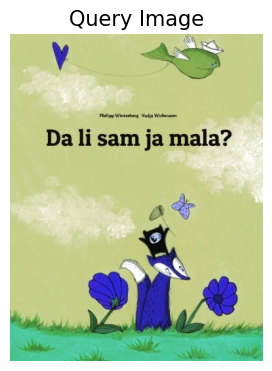

In [ ]:
title_text = ""
plt.figure(figsize=(15,10))
query_image_number = 38
all_possible_genres=[]
# Loading query image
q_image_path = predictions[query_image_number][0]
try:
    req = urllib.request.urlopen(q_image_path)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    q_img = cv2.imdecode(arr, -1)  # Load image as is including alpha channel
except Exception as e:
    print(f"Error downloading or reading image from {q_image_path}: {e}")
        
# Convert BGR to RGB
query_image = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
plt.subplot(2, 4, 1)
plt.axis('off')
plt.title("Query Image",fontsize=15)
plt.imshow(query_image)


#print(len(predictions))
#print(len(predictions[query_image_number]))
#print(len(predictions[query_image_number][1]))

if len(predictions[query_image_number][1]) >= predictions_count:

    for i in range(predictions_count):
        title_text = ""
        new_path = predictions[query_image_number][1][i][1]
        try:
            new_req = urllib.request.urlopen(new_path)
            arr = np.asarray(bytearray(new_req.read()), dtype=np.uint8)
            new_img = cv2.imdecode(arr, -1)  # Load image as is including alpha channel
        except Exception as e2:
            print(f"Error downloading or reading image from {new_path}: {e2}")
            continue

        if new_img is None:
            print(f"Failed to read image from {new_path}")
            continue
        
        # Convert BGR to RGB
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        for j in range(len(data)):
            if data['Image_link'][j] ==predictions[query_image_number][1][i][1]:
                genre = data['Genre'][j]
                all_possible_genres.append(genre)
               # print(data['Title'][i])
              #  print(data['Author'][i])
              #  print(data['Genre'][i])
        title_text = "Matches = " + str(predictions[query_image_number][1][i][0]) + "\n" + "Genre = " + genre
        plt.subplot(2,4,5+i)
        plt.axis('off')
        plt.text(0.5,-0.1,title_text,ha='center',va='center',fontsize=15,transform=plt.subplot(2,4,5+i).transAxes)
        plt.imshow(new_img)
else:
    print("Not enough predictions available for this query image.")
# Loading predicted images
plt.show()




In [ ]:
#get the highest match
highest_match = predictions[query_image_number][1][0][1]
print(highest_match)

#find the book title
for i in range(len(data)):
    if data['Image_link'][i] == highest_match:
        print(data['Title'][i])
        print(data['Author'][i])
        print(data['Genre'][i])
        


http://ecx.images-amazon.com/images/I/51aVpbKpajL.jpg
Am I small?: Wo xiao ma? Children's Picture Book English-Chinese [simplified] (Bilingual Edition) (Chinese Edition)
Philipp Winterberg
Children's Books


### Drawing keypoints and matches for top predicted image

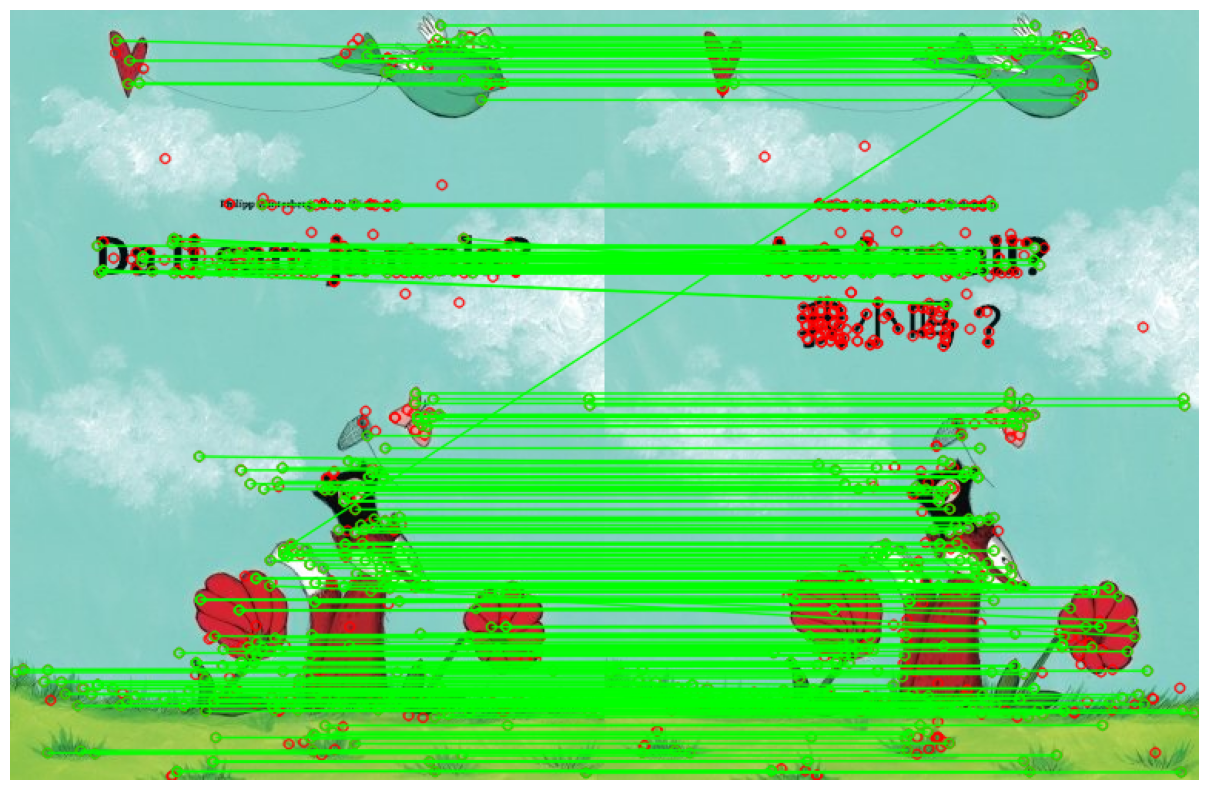

In [ ]:
import random

q_path = predictions[query_image_number][0]

try:
    req = urllib.request.urlopen(q_path)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    q_img = cv2.imdecode(arr, -1)  # Load image as is including alpha channel
except Exception as e:
    print(f"Error downloading or reading image from {q_path}: {e}")

if q_img is None:
    print(f"Failed to read image from {q_path}")

# Convert BGR to RGB
q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)

# Generating SIFT features for query image
q_kp, q_des = gen_sift_features(q_img)

try:
    req2 = urllib.request.urlopen(highest_match)
    arr2 = np.asarray(bytearray(req2.read()), dtype=np.uint8)
    q_img2 = cv2.imdecode(arr2, -1)  # Load image as is including alpha channel
except Exception as e:
    print(f"Error downloading or reading image from {highest_match}: {e}")

if q_img2 is None:
    print(f"Failed to read image from {highest_match}")

# Convert BGR to RGB
q_img2 = cv2.cvtColor(q_img2, cv2.COLOR_BGR2RGB)

m_kp, m_des = gen_sift_features(q_img2)

matches_old = flann.knnMatch(q_des, m_des, k=2)
matches = random.sample(matches_old, 500)

# Need to draw only good matches, so create a mask
matchesMask = [[0, 0] for i in range(len(matches))]

# Ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < lowe_ratio * n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)

kp_img = cv2.drawMatchesKnn(q_img, q_kp, q_img2, m_kp, matches, None, **draw_params)

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(kp_img)
plt.show()


In [ ]:
print(all_possible_genres)

print("highest_match with genre ", all_possible_genres[0])
max_occured_genre = max(set(all_possible_genres), key = all_possible_genres.count)
print("Maximum occuring genre is ",max_occured_genre) 


["Children's Books", "Children's Books", "Children's Books", "Children's Books"]
highest_match with genre  Children's Books
Maximum occuring genre is  Children's Books


In [ ]:
q_image_path = predictions[query_image_number][0]
#print(q_image_path)
#find genre of the query image from dataset
for i in range(len(data)):
    if data['Image_link'][i] == q_image_path:
        original_genre = data['Genre'][i]
        print(original_genre)
        #calculate accuracy
if max_occured_genre == original_genre:
    print("Accuracy is 100%")

Children's Books
Accuracy is 100%
